In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [3]:
train_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
oil_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
stores_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")

In [4]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
test_df.sample(15)

,id,date,store_nbr,family,onpromotion
23027,3023915,2017-08-28,54,PET SUPPLIES,0
14806,3015694,2017-08-24,24,"LIQUOR,WINE,BEER",3
24355,3025243,2017-08-29,42,BABY CARE,0
14052,3014940,2017-08-23,52,PLAYERS AND ELECTRONICS,0
11206,3012094,2017-08-22,23,LADIESWEAR,0
18830,3019718,2017-08-26,37,LAWN AND GARDEN,0
4438,3005326,2017-08-18,33,HOME AND KITCHEN II,0
16405,3017293,2017-08-25,2,BOOKS,0
24760,3025648,2017-08-29,53,EGGS,0
8363,3009251,2017-08-20,43,HARDWARE,0


In [6]:
duplicates = train_df[train_df.duplicated(subset=['date', 'store_nbr', "family"], keep=False)]
duplicates

,id,date,store_nbr,family,sales,onpromotion


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [8]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [9]:
imputer = SimpleImputer(strategy="mean")

In [10]:
oil_df["dcoilwtico"] = imputer.fit_transform(oil_df[["dcoilwtico"]])

In [11]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1218 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [12]:
train_df["date"] = pd.to_datetime(train_df["date"])
test_df["date"] = pd.to_datetime(test_df["date"])
oil_df["date"]=pd.to_datetime(oil_df["date"])

In [13]:
train_df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [14]:
correlation_with_prom = train_df["onpromotion"].corr(train_df["sales"])
correlation_with_prom

0.4279232048121313

In [15]:
correlation_with_oil = oil_df["dcoilwtico"].corr(train_df["sales"])
correlation_with_oil
#too low to use this feature in model

-0.04934306626581533

In [16]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [17]:
train_df = train_df.merge(stores_df, on="store_nbr", how="left").drop("id", axis=1)
ids= test_df["id"]
test_df = test_df.merge(stores_df, on="store_nbr", how="left").drop("id", axis=1)

In [18]:
train_df.sample(10)

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
2187515,2016-05-15,37,FROZEN FOODS,115.00000,4,Cuenca,Azuay,D,2
1512673,2015-05-01,51,LADIESWEAR,0.00000,0,Guayaquil,Guayas,A,17
2357265,2016-08-18,5,DELI,154.77000,8,Santo Domingo,Santo Domingo de los Tsachilas,D,4
332800,2013-07-06,46,POULTRY,1093.80900,0,Quito,Pichincha,A,14
2648746,2017-01-30,29,BABY CARE,2.00000,0,Guayaquil,Guayas,E,10
2111001,2016-04-02,4,MEATS,520.56396,1,Quito,Pichincha,D,9
1235793,2014-11-26,33,DELI,185.00000,0,Quevedo,Los Rios,C,3
341366,2013-07-11,37,HARDWARE,0.00000,0,Cuenca,Azuay,D,2
2110701,2016-04-02,31,LINGERIE,20.00000,0,Babahoyo,Los Rios,B,10
1691408,2015-08-10,17,PET SUPPLIES,3.00000,0,Quito,Pichincha,C,12


In [19]:
avg_sales_by_city= train_df.groupby("city")["sales"].mean().sort_values().reset_index()
avg_sales_by_city

,city,sales
0,Puyo,73.601845
1,Manta,125.173982
2,Playas,138.139340
3,Latacunga,190.583961
4,El Carmen,198.975799
5,Riobamba,204.921881
6,Salinas,205.517129
7,Ibarra,206.061866
8,Santo Domingo,214.942315
9,Guaranda,234.821670


Text(0, 0.5, 'Average sales')

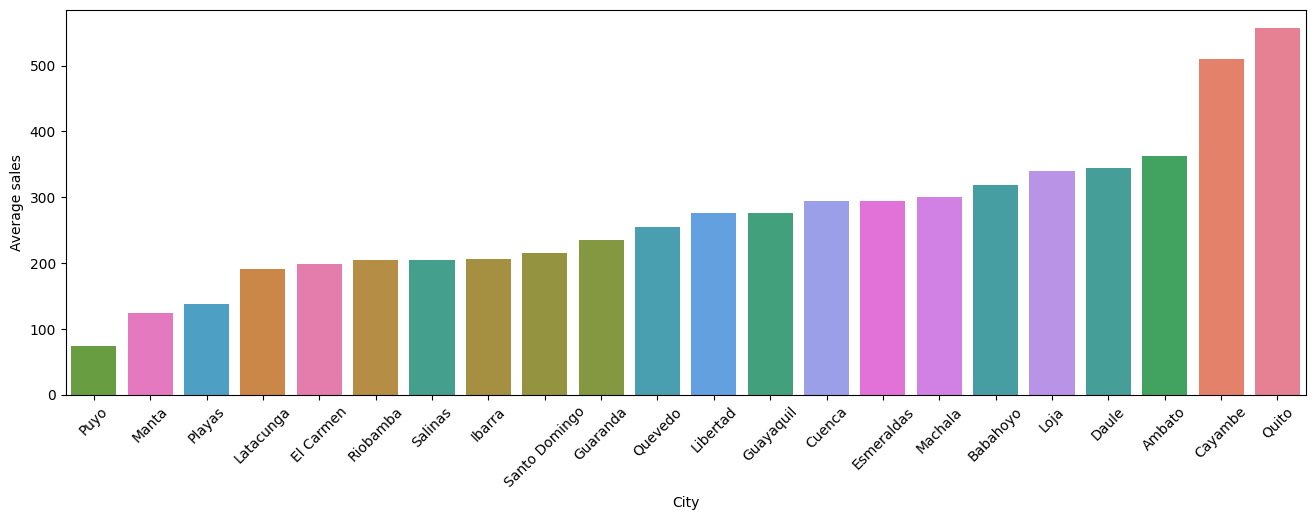

In [20]:
unique_cities = train_df['city'].unique()
color_palette = dict(zip(unique_cities, sns.color_palette("husl", n_colors=len(unique_cities))))
plt.figure(figsize=(16,5))
sns.barplot(x="city", y="sales", data=avg_sales_by_city, palette=color_palette)
plt.xticks(rotation=45)
plt.xlabel("City")
plt.ylabel("Average sales")



In [21]:
sorted_stores = train_df.groupby('store_nbr')['sales'].mean().sort_values().index
store_to_city = train_df.groupby('store_nbr')['city'].first()
store_colors = [color_palette[store_to_city[store]] for store in sorted_stores]

Text(0, 0.5, 'Average sales')

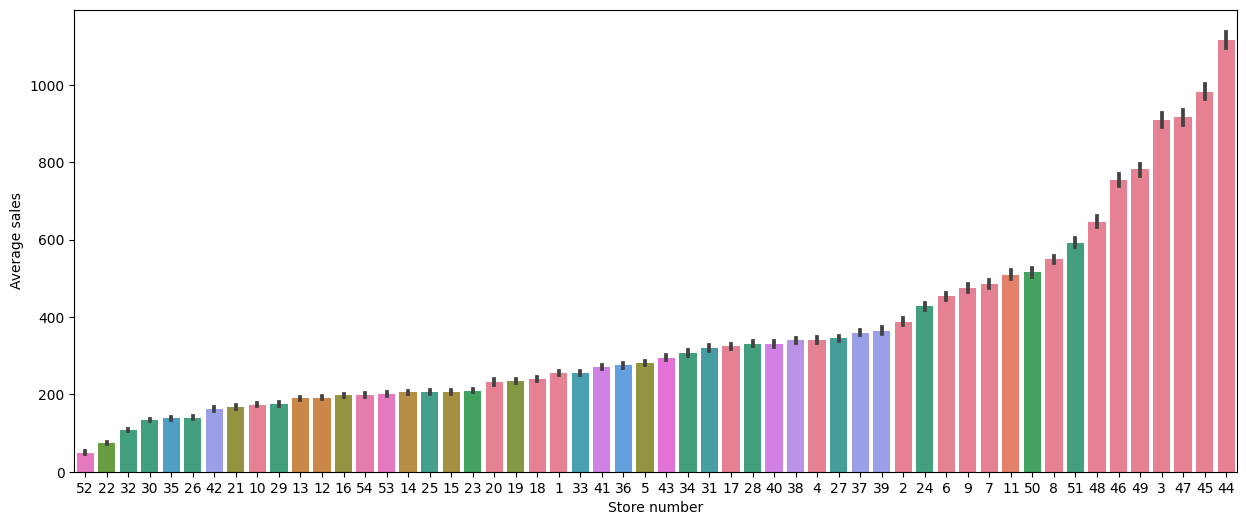

In [22]:
plt.figure(figsize=(15,6))
sns.barplot(data=train_df, x="store_nbr", y="sales", order=sorted_stores, palette=store_colors)
plt.xlabel("Store number")
plt.ylabel("Average sales")
#there's a clear connection between sales number and city where the store is located, but using only the store number is likely giving 
#a better result if its broken down into fewer categories based on sales volume, because of the individual differences in a city


In [23]:
avg_sales_by_store = train_df.groupby('store_nbr')['sales'].mean().sort_values().reset_index()

In [24]:
#bins = [0, 100, 150, 200, 300, 400, 500, 600, 800, 1000, 1120]
#labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#avg_sales_by_store['store_cat'] = pd.cut(avg_sales_by_store['sales'], bins=bins, labels=labels, include_lowest=True)
avg_sales_by_store['store_cat'] =  range(len(avg_sales_by_store))

In [25]:
store_cat_dict = dict(zip(avg_sales_by_store['store_nbr'], avg_sales_by_store['store_cat']))
train_df["store_nbr"] = train_df['store_nbr'].map(store_cat_dict)
test_df["store_nbr"] = test_df["store_nbr"].map(store_cat_dict)

<Axes: xlabel='family', ylabel='sales'>

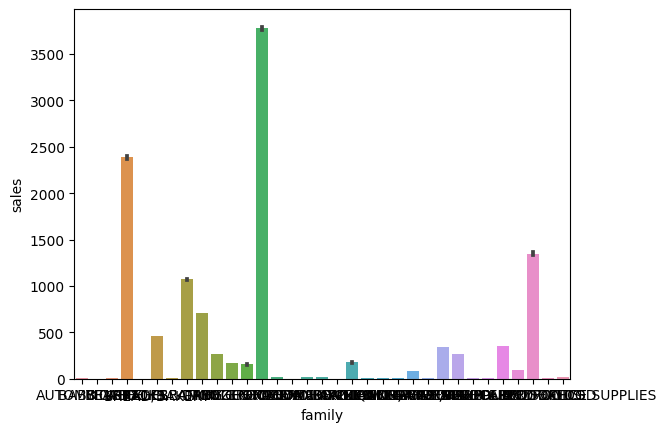

In [26]:
sns.barplot(data=train_df, x="family", y="sales")

In [27]:
avg_sales_by_family= train_df.groupby("family")["sales"].mean().sort_values().reset_index()
avg_sales_by_family

,family,sales
0,BOOKS,0.070797
1,BABY CARE,0.110528
2,HOME APPLIANCES,0.457476
3,HARDWARE,1.137833
4,MAGAZINES,2.929082
5,SCHOOL AND OFFICE SUPPLIES,2.961599
6,BEAUTY,3.715723
7,PET SUPPLIES,3.921263
8,LAWN AND GARDEN,6.035475
9,AUTOMOTIVE,6.101236


In [28]:
avg_sales_by_family['family_cat'] =  range(len(avg_sales_by_family))

In [29]:
avg_sales_by_family

,family,sales,family_cat
0,BOOKS,0.070797,0
1,BABY CARE,0.110528,1
2,HOME APPLIANCES,0.457476,2
3,HARDWARE,1.137833,3
4,MAGAZINES,2.929082,4
5,SCHOOL AND OFFICE SUPPLIES,2.961599,5
6,BEAUTY,3.715723,6
7,PET SUPPLIES,3.921263,7
8,LAWN AND GARDEN,6.035475,8
9,AUTOMOTIVE,6.101236,9


In [30]:
family_cat_dict = dict(zip(avg_sales_by_family['family'], avg_sales_by_family['family_cat']))
train_df["family"] = train_df['family'].map(family_cat_dict)
test_df["family"] = test_df["family"].map(family_cat_dict)

In [31]:
train_df.sample(15)

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
1194821,2014-11-03,23,4,1.000,0,Quevedo,Los Rios,C,3
1091650,2014-09-06,37,21,466.000,0,Cuenca,Azuay,B,6
2673599,2017-02-13,5,27,265.000,12,Guayaquil,Guayas,D,10
2653724,2017-02-02,21,19,62.505,1,Quito,Pichincha,B,16
2229947,2016-06-08,31,27,453.000,11,Guayaquil,Guayas,E,10
297475,2013-06-16,40,16,30.000,0,Quito,Pichincha,D,13
546222,2013-11-03,4,13,0.000,0,Playas,Guayas,C,3
1138445,2014-10-02,46,20,144.498,1,Guayaquil,Guayas,A,17
685527,2014-01-21,27,22,193.000,0,Esmeraldas,Esmeraldas,E,10
2634467,2017-01-22,31,20,69.000,0,Guayaquil,Guayas,E,10


In [32]:
def create_features(df_):
    df = df_.copy()
    
    df["month"] = df.date.dt.month
    df["year"] = df.date.dt.year
    df['dayofweek'] = df.date.dt.dayofweek
    
    return df
train_df_ = create_features(train_df)
test_df = create_features(test_df)

Text(0.5, 1.0, 'Daily Sum of Sales')

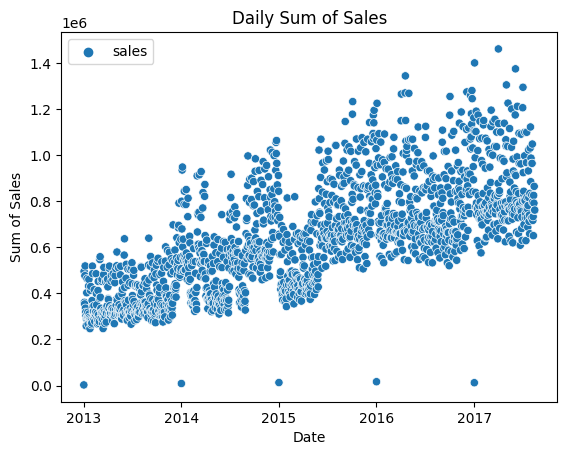

In [33]:
sum_sales_by_date_daily= pd.DataFrame(data = train_df.groupby("date")["sales"].sum())
sns.scatterplot(data=sum_sales_by_date_daily) 
plt.xlabel("Date")
plt.ylabel("Sum of Sales")
plt.title("Daily Sum of Sales")

In [34]:
low_values = sum_sales_by_date_daily[sum_sales_by_date_daily["sales"] < 20000]
low_values

,sales
date,
2013-01-01,2511.618999
2014-01-01,8602.065404
2015-01-01,12773.616980
2016-01-01,16433.394000
2017-01-01,12082.500997


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


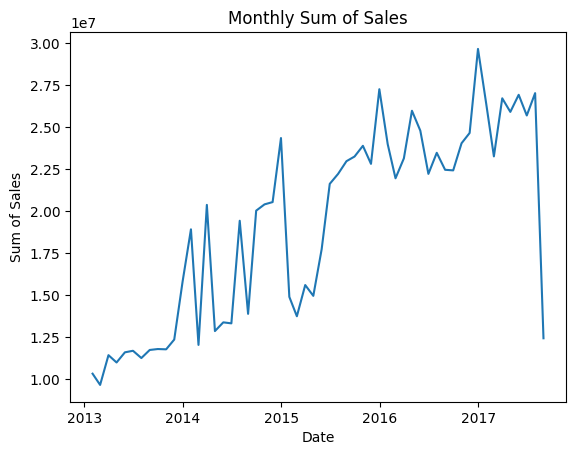

In [35]:
monthly_sales = train_df.resample('ME', on='date')['sales'].sum().reset_index()
sns.lineplot(data=monthly_sales, x='date', y='sales')
plt.xlabel("Date")
plt.ylabel("Sum of Sales")
plt.title("Monthly Sum of Sales")
plt.show()

In [36]:
test_df

,date,store_nbr,family,onpromotion,city,state,type,cluster,month,year,dayofweek
0,2017-08-16,22,9,0,Quito,Pichincha,D,13,8,2017,2
1,2017-08-16,22,1,0,Quito,Pichincha,D,13,8,2017,2
2,2017-08-16,22,6,2,Quito,Pichincha,D,13,8,2017,2
3,2017-08-16,22,31,20,Quito,Pichincha,D,13,8,2017,2
4,2017-08-16,22,0,0,Quito,Pichincha,D,13,8,2017,2
...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,41,26,1,Quito,Pichincha,B,6,8,2017,3
28508,2017-08-31,41,19,0,Quito,Pichincha,B,6,8,2017,3
28509,2017-08-31,41,30,1,Quito,Pichincha,B,6,8,2017,3
28510,2017-08-31,41,5,9,Quito,Pichincha,B,6,8,2017,3


In [37]:
X_train = train_df_.drop(["city", "state", "type", "cluster", "date"], axis=1).copy()
X_test = test_df.drop(["city", "state", "type", "cluster", "date"], axis=1)
y_train = np.log1p(X_train.pop("sales"))

In [38]:
y_train

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
             ...   
3000883    6.084802
3000884    5.046987
3000885    7.791824
3000886    4.804021
3000887    2.833213
Name: sales, Length: 3000888, dtype: float64

In [39]:
params = {'lambda': 6.105970537016599, 'alpha': 0.874716179324655, 'eta': 0.047228549789593455, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.015, 'n_estimators': 2000, 'max_depth': 17, 'min_child_weight': 155}

In [40]:
xgb_model = xgb.XGBRegressor(**params)

In [41]:
xgb_model.fit(X_train, y_train)

XGBRegressor(alpha=0.874716179324655, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.047228549789593455,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             lambda=6.105970537016599, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=17, max_leaves=None,
             min_child_weight=155, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1600, ...)

In [42]:
y_pred = xgb_model.predict(X_test)


In [43]:
test_df["predictions"] = np.expm1(y_pred)

In [44]:
test_df

,date,store_nbr,family,onpromotion,city,state,type,cluster,month,year,dayofweek,predictions
0,2017-08-16,22,9,0,Quito,Pichincha,D,13,8,2017,2,4.148007
1,2017-08-16,22,1,0,Quito,Pichincha,D,13,8,2017,2,0.077295
2,2017-08-16,22,6,2,Quito,Pichincha,D,13,8,2017,2,5.604530
3,2017-08-16,22,31,20,Quito,Pichincha,D,13,8,2017,2,2685.698975
4,2017-08-16,22,0,0,Quito,Pichincha,D,13,8,2017,2,0.206900
...,...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,41,26,1,Quito,Pichincha,B,6,8,2017,3,371.596649
28508,2017-08-31,41,19,0,Quito,Pichincha,B,6,8,2017,3,94.141388
28509,2017-08-31,41,30,1,Quito,Pichincha,B,6,8,2017,3,1161.653076
28510,2017-08-31,41,5,9,Quito,Pichincha,B,6,8,2017,3,71.527832


In [45]:
test_sum_sales_by_date_daily= pd.DataFrame(data = test_df.groupby("date")["predictions"].sum().reset_index())
sum_sales_by_date_daily= pd.DataFrame(data = train_df.groupby("date")["sales"].sum().reset_index())

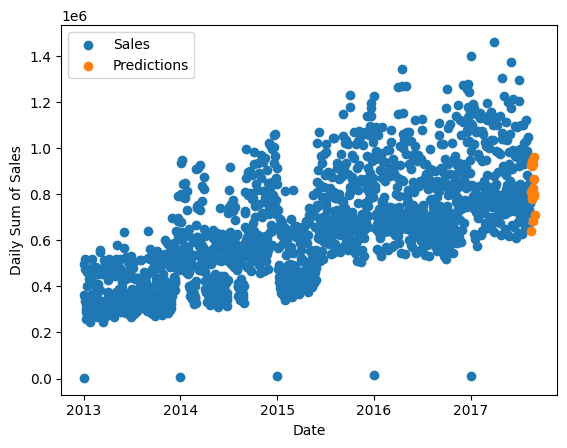

In [46]:
plt.scatter(sum_sales_by_date_daily["date"], sum_sales_by_date_daily["sales"])
plt.scatter(test_sum_sales_by_date_daily["date"], test_sum_sales_by_date_daily["predictions"])
plt.xlabel("Date")
plt.ylabel("Daily Sum of Sales")
plt.legend(["Sales", "Predictions"])
plt.show()

In [47]:
subset_sales = sum_sales_by_date_daily.iloc[-20:]

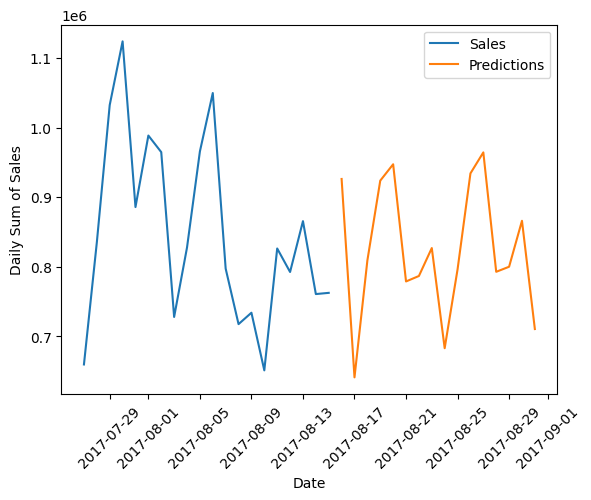

In [52]:
plt.plot(subset_sales["date"], subset_sales["sales"])
plt.plot(test_sum_sales_by_date_daily["date"], test_sum_sales_by_date_daily["predictions"])
plt.xlabel("Date")
plt.ylabel("Daily Sum of Sales")
plt.xticks(rotation=45)
plt.legend(["Sales", "Predictions"])
plt.show()

In [49]:
output = pd.DataFrame({'Id': ids, 'sales': np.expm1(y_pred)})
output.to_csv('submission.csv', index=False)

In [50]:
output

,Id,sales
0,3000888,4.148007
1,3000889,0.077295
2,3000890,5.604530
3,3000891,2685.698975
4,3000892,0.206900
...,...,...
28507,3029395,371.596649
28508,3029396,94.141388
28509,3029397,1161.653076
28510,3029398,71.527832
